In [1]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prompt_templates import *
import torch
import random
import warnings
import numpy as np
warnings.filterwarnings('ignore')


In [2]:
MODEL_PATH = {#"Gemma-7b-it" : "../models/gemma-7b-it.gguf",
              "Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               "Phi-2": "../models/phi-2.Q5_K_M.gguf",
               "Llama2-70b": "../models/llama2_70b_chat_uncensored.Q5_K_M.gguf",
               "Yi-34b": "../models/yi-34b-200k.Q5_K_M.gguf",
               "Dolphin-2.5": "../models/dolphin-2.5-mixtral-8x7b.Q5_K_M.gguf",
              }

#Set output file name
OUTPUT_EVALUATION = "../data/llm_201_301.pkl"

#Filename output evaluation detailed
OUTPUT_EVALUATION_DETAILED = "../data/llm_prob_result_detailed_201_301.pkl"

#Sampling rate determines how often a question is asked again if the answer format is wrong
MAX_SAMPLING_RATE = 5

#Set to 1 if you dont want to shuffle
NUM_OF_SHUFFLES = 5

#Parameter for changing the temperature of the model
TEMPERATURE = 0.5

FEW_SHOT_TEMPLATE = """
    The following are multiple choice questions (with answers) about network fundamentals, network access,
    security fundamentals, automation and programmability. Here is an example
    
    Question: Which two options are the best reasons to use an IPV4 private IP space? (Choose two.)
    
    Choices:
    A. to enable intra-enterprise communication
    B. to implement NAT
    C. to connect applications
    D. to conserve global address space
    E. to manage routing overhead
                                               
    Correct Answer: ['A','D']
    
    Please give the answer in the following format:
        Correct Answer: ['A','D']           
    
    Now, answer the following question:
    Question: {Exam_Question}        
                    
    Choices:
    {Exam_Choices}
    """

SHUFFLE_PROB_ENB = False



In [3]:
def extract_answer(answer):
    """Extracts the correct answers from the provided answer string.

    Args:
        answer: The answer string to extract the correct answers from.

    Returns:
        A list of correct answers (e.g., ['A', 'B']) if found, otherwise None. 
    """

    pattern = r"""
        ^\s*                
        Correct\s+Answer:\s+  
        \[                  
        ['ABCDET\s,]+      
        \]                  
        \s*                 
    """
    match = re.search(pattern, answer, flags=re.VERBOSE)
    if match:
        # Extract the answer portion within the brackets
        answer_section = match.group(0).split('[')[1].split(']')[0]

        # Find individual answers (consider making this more robust if needed)
        correct_answers = answer_section.strip().split(',')
        return [ans.strip().strip("'") for ans in correct_answers]

    else:
        return None

def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """

    # Convert the answer_exam string to a list of answers
    answer_exam_list = answer_exam.split(" ")
    #Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam_list)
    

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam_list)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True

    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def evaluation_sampling(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_answer(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly
    else:
         return -1


#####
# Partial Credit allowed?
####
def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Precision and Recall and f1 score
    precision = correctly_answered / number_of_questions
    precision_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Precision': precision,
        'Precision Partial': precision_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation(evaluation_df):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Precision Mean', 'Precision Min', 'Precision Max'
        - 'Precision Partial Mean', 'Precision Partial Min', 'Precision Partial Max'
    """

    # Define a list of colors for the models
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Precision ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[0].bar(i + bar_width * i, evaluation_df.loc[i, 'Precision Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Precision Mean'] - evaluation_df.loc[i, 'Precision Min'])], [abs(evaluation_df.loc[i, 'Precision Max'] - evaluation_df.loc[i, 'Precision Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[0].set_ylabel('Precision (%)')
    axs[0].set_title('Precision Mean with Error Bars (Max and Min)', fontsize=12)
    axs[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()
    axs[0].set_ylim([0, 1])
    axs[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].grid(True, linestyle='dotted', axis='y')

    # --- Subplot 2: Partial Precision ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Precision Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Precision Partial Mean'] - evaluation_df.loc[i, 'Precision Partial Min'])], [abs(evaluation_df.loc[i, 'Precision Partial Max'] - evaluation_df.loc[i, 'Precision Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[1].set_ylabel('Precision Partial (%)')
    axs[1].set_title('Precision Partial Mean with Error Bars (Max and Min)', fontsize=12)
    axs[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[1].legend()
    axs[1].set_ylim([0, 1])
    axs[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].grid(True, linestyle='dotted', axis='y')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots
    plt.show()

def extract_answer_from_text_file(path_to_text_file):
   # Read the text file
    with open(path_to_text_file, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    questions = []
    answers = []
    correct_answers = []

    # Parse the lines
    question = ""
    options = ""
    correct_option = ""
    for line in lines:
        line = line.strip()
        if line.startswith("Question:"):
            if question:  # If it's not the first question
                questions.append(question)
                answers.append(options)
                correct_answers.append(correct_option)
                options = ""  # Reset options for the new question
            question = line.replace("Question:", "").strip()
        elif line.startswith("Answer:"):
            correct_option = line.split(":")[-1].strip()
        elif line.startswith(("A.", "B.", "C.", "D.", "E.", "F.", "G.")):
            options += line.strip() + " "  # Add options to the string

    # Append the last question
    questions.append(question)
    answers.append(options)
    correct_answers.append(correct_option)

    # Create a DataFrame
    data = {
        'Question': questions,
        'Answers': answers,
        'Correct Answer': correct_answers
    }

    df = pd.DataFrame(data)
    return df


def split_options_string(options_string):
    # Use regular expression to split the string
    options_list = re.split(r'\n(?=[A-Z]\. )', options_string)
    
    # Remove any leading or trailing whitespace from each option
    options_list = [option.strip() for option in options_list if option.strip()]
    
    return options_list

def format_options_string(options_list):
    # Join the options list with newline characters
    formatted_options_string = '\n'.join(options_list)
    
    return formatted_options_string


def evaluation_probability(char_prob_list, llm_answer, exam_answers, num_of_correct_answer):
    # Normalize probabilities
    total = sum(char_prob_list.values())
    for letter in char_prob_list:
        char_prob_list[letter] /= total


    # Sort characters by probability
    sorted_chars = sorted(char_prob_list.items(), key=lambda item: item[1], reverse=True)
    # Select answers based on the number of correct answers for the question
    answerLLm = [char for char, prob in sorted_chars[:num_of_correct_answer]]
    num_of_correct_llm_answer, too_many_answers = compare_answers(answerLLm, exam_answers)
    
    if num_of_correct_llm_answer == num_of_correct_answer and too_many_answers == False:
        answered_correctly = True
    else :
        answered_correctly = False
    return num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly

def extract_exam_info(examQuestion):
    #Extracting the question, answer and choices from the dataframe
    question = examQuestion[0].strip()  # Get the value of the first column (question) and remove leading/trailing whitespace
    answer_exam = examQuestion[2].strip()    # Get the value of the third column (answer) and remove leading/trailing whitespace
    answer_exam_with_whitespace = ' '.join(list(answer_exam))

    #Set the number of correct answers
    num_of_correct_answer = len([char for char in answer_exam_with_whitespace if char != ' '])

    #Create the choices string like in the prompt template
    choices = ""  # Reset the choices variable for each question
    choices = split_options_string(examQuestion[1])
    choices = format_options_string(choices)

    return question, choices, answer_exam_with_whitespace, num_of_correct_answer


def shuffle_choices(choices_string, answers):
    # Split the input string into a list of choices
    choices = re.split(r'\n(?=[A-Z]\. )', choices_string)
    
    # Create a dictionary to track the original and new letters of the choices
    letter_map = {}
    
    # Shuffle the list
    random.shuffle(choices)
    
    # Reassign the choice letters
    shuffled_string = ""
    for i, choice in enumerate(choices):
        original_letter, rest_of_choice = choice.split(". ", 1)
        new_letter = chr(65 + i)
        shuffled_string += new_letter + ". " + rest_of_choice + "\n"
        
        # Update the letter map
        letter_map[original_letter] = new_letter
    
    # Split the answers string into a list of answer letters
    answers = answers.split()
    
    # Update the answers
    new_answers = [letter_map[answer] for answer in answers]
    
    return shuffled_string.strip(), ' '.join(new_answers)

def calculate_model_statistics(df):
    """
    Calculates statistics for each model in the DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing evaluation metrics for different models.
    
    Returns:
    DataFrame: New DataFrame containing calculated statistics for each model.
    """
    model_stats = []
    for model, group_df in df.groupby('Model'):
        model_stat = {
            'Model': model,
            'Precision Mean': group_df['Precision'].mean(),
            'Precision Max': group_df['Precision'].max(),
            'Precision Min': group_df['Precision'].min(),
            'Precision STD': group_df['Precision'].std(),
            'Precision Partial Mean': group_df['Precision Partial'].mean(),
            'Precision Partial Max': group_df['Precision Partial'].max(),
            'Precision Partial Min': group_df['Precision Partial'].min(),
            'Precision Partial STD': group_df['Precision Partial'].std()
        }
        model_stats.append(model_stat)
    
    return pd.DataFrame(model_stats)

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 2 CUDA devices:
  Device 0: NVIDIA A100-SXM4-40GB, compute capability 8.0, VMM: yes
  Device 1: NVIDIA A100-SXM4-40GB, compute capability 8.0, VMM: yes
llama_model_loader: loaded meta data with 25 key-value pairs and 995 tensors from ../models/dolphin-2.5-mixtral-8x7b.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = ehartford_dolphin-2.5-mixtral-8x7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,2,0.5,"[A, C]",A D,False,False
1,Dolphin-2.5,1,0,1,1,1.0,[A],A,True,False
2,Dolphin-2.5,2,0,1,1,1.0,[A],A,True,False
3,Dolphin-2.5,3,0,0,1,0.0,[A],C,False,False
4,Dolphin-2.5,4,0,1,1,1.0,[C],C,True,False
...,...,...,...,...,...,...,...,...,...,...
199,Dolphin-2.5,199,0,0,1,0.0,[C],A,False,False
200,Dolphin-2.5,200,0,1,1,1.0,[D],D,True,False
201,Dolphin-2.5,201,0,0,1,0.0,[A],D,False,False
202,Dolphin-2.5,202,0,1,1,1.0,[C],C,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,204,110,94,0.539216,0.690763,Dolphin-2.5


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,2,0.5,"[B, E]",E A,False,False
1,Dolphin-2.5,1,0,1,1,1.0,[C],C,True,False
2,Dolphin-2.5,2,0,1,1,1.0,[D],D,True,False
3,Dolphin-2.5,3,0,0,1,0.0,[A],C,False,False
4,Dolphin-2.5,4,0,1,1,1.0,[D],D,True,False
...,...,...,...,...,...,...,...,...,...,...
199,Dolphin-2.5,199,1,0,1,0.0,[B],D,False,False
200,Dolphin-2.5,200,0,1,1,1.0,[D],D,True,False
201,Dolphin-2.5,201,0,0,1,0.0,[A],B,False,False
202,Dolphin-2.5,202,0,1,1,1.0,[D],D,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,204,110,94,0.539216,0.690763,Dolphin-2.5
1,204,87,117,0.426471,0.690763,Dolphin-2.5


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,2,0.5,"[A, E]",A B,False,False
1,Dolphin-2.5,1,0,1,1,1.0,[A],A,True,False
2,Dolphin-2.5,2,0,0,1,0.0,[A],B,False,False
3,Dolphin-2.5,3,0,1,1,1.0,"[A, B, D]",D,False,True
4,Dolphin-2.5,4,0,1,1,1.0,[A],A,True,False
...,...,...,...,...,...,...,...,...,...,...
199,Dolphin-2.5,199,0,0,1,0.0,[B],C,False,False
200,Dolphin-2.5,200,0,1,1,1.0,[A],A,True,False
201,Dolphin-2.5,201,0,0,1,0.0,[A],C,False,False
202,Dolphin-2.5,202,0,1,1,1.0,[D],D,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,204,110,94,0.539216,0.690763,Dolphin-2.5
1,204,87,117,0.426471,0.690763,Dolphin-2.5
2,204,105,99,0.514706,0.698795,Dolphin-2.5


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,2,2,1.0,"[B, C]",C B,True,False
1,Dolphin-2.5,1,0,1,1,1.0,[C],C,True,False
2,Dolphin-2.5,2,0,0,1,0.0,[C],D,False,False
3,Dolphin-2.5,3,0,0,1,0.0,[C],B,False,False
4,Dolphin-2.5,4,0,1,1,1.0,[D],D,True,False
...,...,...,...,...,...,...,...,...,...,...
199,Dolphin-2.5,199,0,0,1,0.0,[A],B,False,False
200,Dolphin-2.5,200,0,1,1,1.0,[B],B,True,False
201,Dolphin-2.5,201,0,1,1,1.0,[A],A,True,False
202,Dolphin-2.5,202,1,1,1,1.0,[B],B,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,204,110,94,0.539216,0.690763,Dolphin-2.5
1,204,87,117,0.426471,0.690763,Dolphin-2.5
2,204,105,99,0.514706,0.698795,Dolphin-2.5
3,204,106,98,0.519608,0.686747,Dolphin-2.5


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,2,0.5,"[B, C]",E C,False,False
1,Dolphin-2.5,1,0,1,1,1.0,[B],B,True,False
2,Dolphin-2.5,2,0,1,1,1.0,[C],C,True,False
3,Dolphin-2.5,3,0,0,1,0.0,[A],C,False,False
4,Dolphin-2.5,4,0,1,1,1.0,[C],C,True,False
...,...,...,...,...,...,...,...,...,...,...
199,Dolphin-2.5,199,0,0,1,0.0,[A],C,False,False
200,Dolphin-2.5,200,0,1,1,1.0,[A],A,True,False
201,Dolphin-2.5,201,0,0,1,0.0,[A],B,False,False
202,Dolphin-2.5,202,0,1,1,1.0,[A],A,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,204,110,94,0.539216,0.690763,Dolphin-2.5
1,204,87,117,0.426471,0.690763,Dolphin-2.5
2,204,105,99,0.514706,0.698795,Dolphin-2.5
3,204,106,98,0.519608,0.686747,Dolphin-2.5
4,204,103,101,0.504902,0.658635,Dolphin-2.5


,Model,Precision Mean,Precision Max,Precision Min,Precision STD,Precision Partial Mean,Precision Partial Max,Precision Partial Min,Precision Partial STD
0,Dolphin-2.5,0.50098,0.539216,0.426471,0.043487,0.685141,0.698795,0.658635,0.01545


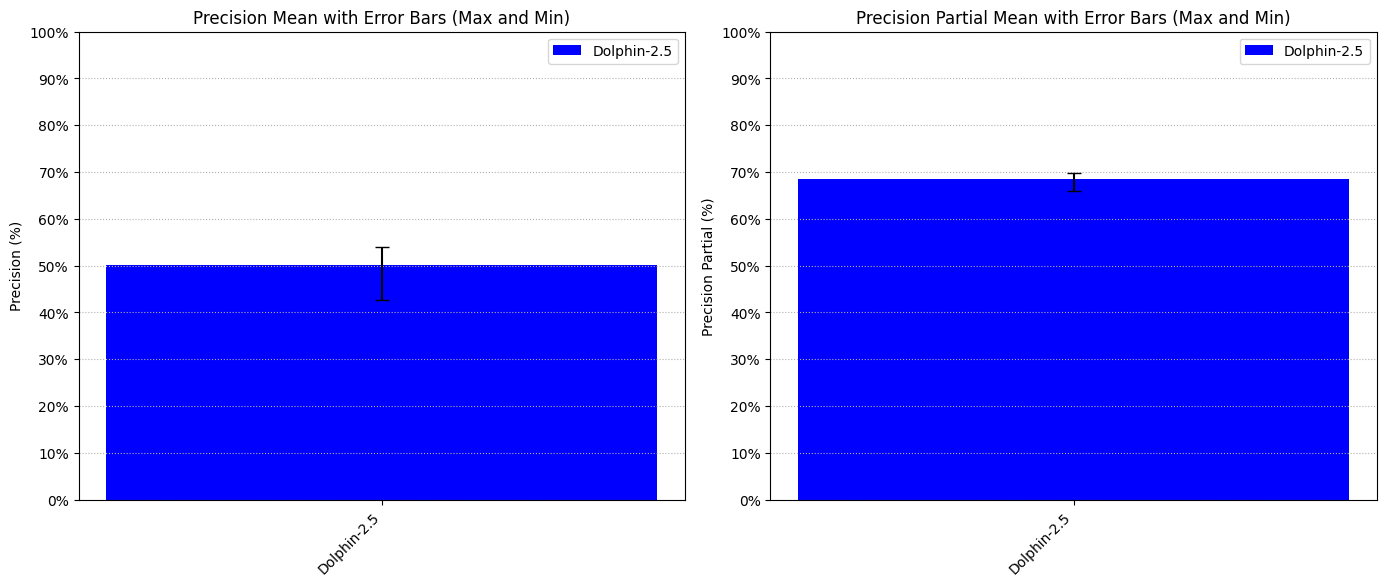

In [4]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Precision','Precision Partial'])
questions  = pd.read_excel("../data/201-301-CCNA.xlsx")

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(FEW_SHOT_TEMPLATE)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        #TEMPERATURE !! --> Temperature Sampling
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        for index_question, row in questions.iterrows():
            #Extract the question, answer and choices from the dataframe
            question, choices, answers, num_of_correct_answer = extract_exam_info(row)
            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices(choices, answers)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices
                llm_answer = chain.invoke({"Exam_Question" : question, "Exam_Choices" : choices})            

                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:

                    #If probability is enabled, check what the correct answer is after all the sampling
                    if not SHUFFLE_PROB_ENB:
                        # Extract the correct answers from the LLM answer and analyse the answer
                        num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                        #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                        sample_Index = index_sampling
                        valid_question_answer = True
                        break
                    else:
                        answer_letters = extract_answer(llm_answer)
                        sample_Index = index_sampling
                        valid_question_answer = True
                        #Shuffle the choices
                        choices = shuffle_choices(choices, answers)
                        for letter in answer_letters:
                            if letter in char_probabilities:
                                char_probabilities[letter] += 1
                            else:
                                char_probabilities[letter] = 1
            
            if SHUFFLE_PROB_ENB:
                num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_probability(char_probabilities, llm_answer, answers, num_of_correct_answer)
        
                        
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        llm_exam_result.to_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)

#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)


Model: Dolphin-2.5


,Model,Precision Mean,Precision Max,Precision Min,Precision STD,Precision Partial Mean,Precision Partial Max,Precision Partial Min,Precision Partial STD
0,Dolphin-2.5,0.50098,0.539216,0.426471,0.040261,0.685141,0.698795,0.658635,0.014304


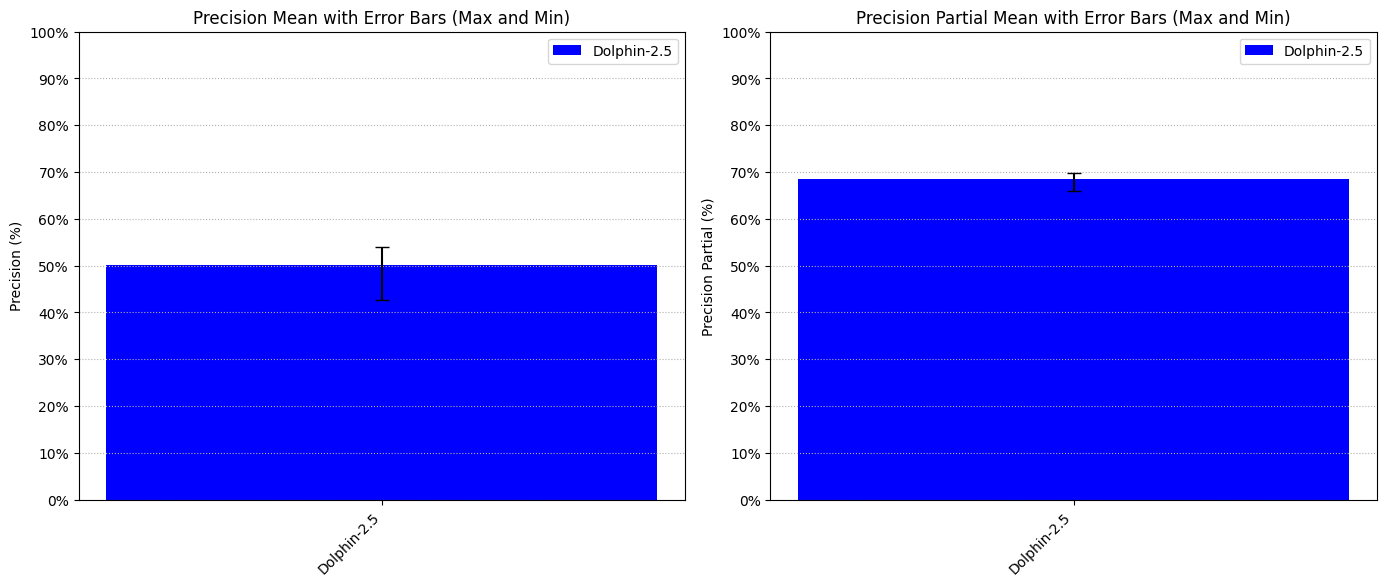

In [6]:
for model, model_path in MODEL_PATH.items():
    print(f"Model: {model}")
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.read_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)